# Results analyses

This notebook was designed to take the predictions generated after training the models, and performing results analyses based on several metrics.

## Basic imports

In [1]:
import pandas as pd
from sklearn import metrics
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kn6__xow because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Functions for classification models

Below are the definitions of functions to evaluate the classification models.

In [2]:
def eval_model(dfs):
    acc_list = list()
    bal_acc_list = list()
    prec_macro_list = list()
    prec_micro_list = list()
    rec_macro_list = list()
    f1_macro_list = list()
    f1_micro_list = list()
    
    for df in dfs:
        acc = metrics.accuracy_score(df['y_true'], df['y_pred'])
        balanced_acc = metrics.balanced_accuracy_score(df['y_true'], df['y_pred'])
        precision_macro = metrics.precision_score(df['y_true'], df['y_pred'], average='macro')
        recall_macro = metrics.recall_score(df['y_true'], df['y_pred'], average='macro')
        f1_macro = metrics.f1_score(df['y_true'], df['y_pred'], average='macro')
        f1_micro = metrics.f1_score(df['y_true'], df['y_pred'], average='micro')
        
        acc_list.append(acc)
        bal_acc_list.append(balanced_acc)
        prec_macro_list.append(precision_macro)
        rec_macro_list.append(recall_macro)
        f1_macro_list.append(f1_macro)
        f1_micro_list.append(f1_micro)

    print('Accuracy')
    print('Mean:', np.mean(acc_list), ', Std:', np.std(acc_list))
    print('Balanced accuracy')
    print('Mean:', np.mean(bal_acc_list), ', Std:', np.std(bal_acc_list))
    print('Precision macro')
    print('Mean:', np.mean(prec_macro_list), ', Std:', np.std(prec_macro_list))
    print('Recall macro')
    print('Mean:', np.mean(rec_macro_list), ', Std:', np.std(rec_macro_list))
    print('F1 macro')
    print('Mean:', np.mean(f1_macro_list), ', Std:', np.std(f1_macro_list))
    print('F1 micro')
    print('Mean:', np.mean(f1_micro_list), ', Std:', np.std(f1_micro_list))

In [3]:
def avg_cf(dfs, ax, lbl_names=None):
    cf_list = list()
    
    for df in dfs:
        cf = metrics.confusion_matrix(df['y_true'], df['y_pred'],normalize='true')
        cf_list.append(cf)
    cf_mean = np.mean(cf_list, axis=0)
    
    sns.heatmap(cf_mean, vmin=0, vmax=1, annot=True, fmt='0.2f', cbar=False, cmap='coolwarm', ax=ax)
    if lbl_names is not None:
        ax.set_xticklabels(lbl_names)
        ax.set_yticklabels(lbl_names)
    return ax

In [4]:
from sklearn.dummy import DummyClassifier

def compute_dummy(df, strategy='prior'):
    clf = DummyClassifier(strategy=strategy)
    clf.fit(df['y_true'], df['y_true'])
    df['y_pred'] = clf.predict(df['y_true'])
    return df

In [5]:
def eval_all(base_paths, lbl_names=None, dummy_strategy=None):
    for base_path in base_paths:
        dfs = list()
        print('\n', base_path)
        for i in range(4):
            path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
            df = pd.read_csv(path, index_col=0)
            if dummy_strategy is not None:
                df = compute_dummy(df, dummy_strategy)
            dfs.append(df)
        eval_model(dfs)
        #fig, ax = plt.subplots()
        #avg_cf(dfs, ax, lbl_names=lbl_names)
        #plt.show()

# Evaluating models that classify the absolute water level

Below, I evaluate the models aimed at, given an input image or a sequence of input images, classify it according to the water level.
So far, the classes are *low*, *medium*, *high* and *flood*.

In [6]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

In [7]:
lbl_names = ['low', 'medium', 'high', 'flood']
eval_all(base_paths, lbl_names=lbl_names)


 /models/single_rgb_v1
Accuracy
Mean: 0.9575422839902221 , Std: 0.026900727588661237
Balanced accuracy
Mean: 0.6441085060695999 , Std: 0.062376137221326476
Precision macro
Mean: 0.46441243494058676 , Std: 0.12255792512622714
Recall macro
Mean: 0.6441085060695999 , Std: 0.062376137221326476
F1 macro
Mean: 0.48445719648954677 , Std: 0.10685096613971372
F1 micro
Mean: 0.9575422839902221 , Std: 0.026900727588661237

 /models/rgbdiff_v0
Accuracy
Mean: 0.9146837736846568 , Std: 0.06237258867585894
Balanced accuracy
Mean: 0.5449605086183015 , Std: 0.092944875381137
Precision macro
Mean: 0.34085520640795797 , Std: 0.05788298065333244
Recall macro
Mean: 0.5449605086183015 , Std: 0.092944875381137
F1 macro
Mean: 0.36945248591805924 , Std: 0.08252076989944619
F1 micro
Mean: 0.9146837736846568 , Std: 0.06237258867585896

 /models/pair_gray_v0
Accuracy
Mean: 0.9685689185202366 , Std: 0.009258862556722732
Balanced accuracy
Mean: 0.678835105740956 , Std: 0.11617149789928129
Precision macro
Mean: 0.4

## Dummy classifiers

Here, I evaluate a set of dummy classifiers as baselines.

In [8]:
print('Majority class')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='prior')

print('\n\nStratified random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='stratified')

print('\n\nUniform random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='uniform')

Majority class

 /models/single_rgb_v1
Accuracy
Mean: 0.9890870570007655 , Std: 0.0026106963321152034
Balanced accuracy
Mean: 0.25 , Std: 0.0
Precision macro
Mean: 0.24727176425019137 , Std: 0.0006526740830288009
Recall macro
Mean: 0.25 , Std: 0.0
F1 macro
Mean: 0.24862796547441393 , Std: 0.00032955461620516477
F1 micro
Mean: 0.9890870570007655 , Std: 0.0026106963321152034


Stratified random

 /models/single_rgb_v1
Accuracy
Mean: 0.979009747967142 , Std: 0.0052751185087192695
Balanced accuracy
Mean: 0.2494221812022929 , Std: 0.00328970963979937
Precision macro
Mean: 0.2497203265994093 , Std: 0.003978944201148729
Recall macro
Mean: 0.2494221812022929 , Std: 0.00328970963979937
F1 macro
Mean: 0.24954590505648366 , Std: 0.0035943863917169885
F1 micro
Mean: 0.979009747967142 , Std: 0.0052751185087192695


Uniform random

 /models/single_rgb_v1
Accuracy
Mean: 0.25096266222908714 , Std: 0.000669388911423962
Balanced accuracy
Mean: 0.27663916168111397 , Std: 0.03667890895848769
Precision mac

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

# Evaluating models that classify the relative water level

Below, I evaluate the models aimed at, given a pair of input images or a sequence of such pairs, identify if the water level is stable, if it is increasing, or if it is decreasing.
So far, the classes are *up*, *down*, and *still*.

In [9]:
base_paths = list()
base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')

In [10]:
lbl_names = ['down', 'still', 'up']
eval_all(base_paths, lbl_names=lbl_names)


 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.8623987834505298 , Std: 0.10199022334391561
Balanced accuracy
Mean: 0.6695839029256397 , Std: 0.14332866570798905
Precision macro
Mean: 0.35260796588122445 , Std: 0.010089508886513337
Recall macro
Mean: 0.6695839029256397 , Std: 0.14332866570798905
F1 macro
Mean: 0.34416672084806416 , Std: 0.03446466402460696
F1 micro
Mean: 0.8623987834505298 , Std: 0.10199022334391561

 /models/rgbdiff_diffs_v0
Accuracy
Mean: 0.9072748516576283 , Std: 0.07016718888984719
Balanced accuracy
Mean: 0.625736644252991 , Std: 0.011918298979364967
Precision macro
Mean: 0.353851617812566 , Std: 0.011256832133127628
Recall macro
Mean: 0.625736644252991 , Std: 0.011918298979364967
F1 macro
Mean: 0.35439408786374904 , Std: 0.029364959360361678
F1 micro
Mean: 0.9072748516576283 , Std: 0.0701671888898472

 /models/pair_gray_diffs_v0
Accuracy
Mean: 0.981880919893058 , Std: 0.006006861527120195
Balanced accuracy
Mean: 0.7442190589593137 , Std: 0.1611190230524627
Precisio

## Dummy classifiers

In [11]:
print('Majority class')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='prior')

print('\n\nStratified random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='stratified')

print('\n\nUniform random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='uniform')

Majority class

 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.9962205480811681 , Std: 0.000590735748925158
Balanced accuracy
Mean: 0.3333333333333333 , Std: 0.0
Precision macro
Mean: 0.33207351602705604 , Std: 0.00019691191630838412
Recall macro
Mean: 0.3333333333333333 , Std: 0.0
F1 macro
Mean: 0.3327022028171166 , Std: 9.885759647760516e-05
F1 micro
Mean: 0.9962205480811681 , Std: 0.000590735748925158


Stratified random

 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.9922531494379261 , Std: 0.0015059224464155853
Balanced accuracy
Mean: 0.3320056938141093 , Std: 0.00033414974490625154
Precision macro
Mean: 0.33206834086931014 , Std: 0.00019891056372689752
Recall macro
Mean: 0.3320056938141093 , Std: 0.00033414974490625154
F1 macro
Mean: 0.33203697963851386 , Std: 0.0002531409343238463
F1 micro
Mean: 0.9922531494379261 , Std: 0.0015059224464155853


Uniform random

 /models/single_rgb_diffs_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Accuracy
Mean: 0.3356057316994553 , Std: 0.004606898537576213
Balanced accuracy
Mean: 0.3107197234073389 , Std: 0.008968358466929522
Precision macro
Mean: 0.3330930046279296 , Std: 0.00019377209850752659
Recall macro
Mean: 0.3107197234073389 , Std: 0.008968358466929522
F1 macro
Mean: 0.16965133297083526 , Std: 0.0016687666602081723
F1 micro
Mean: 0.3356057316994553 , Std: 0.004606898537576213


# Deployable figures

### Ensure creation of results folder

In [12]:
os.makedirs(os.path.join('..','results'))

## Confusion matrices

In [13]:
def provide_all_subplots(base_paths, plot_titles, figsize=(10,8), lbl_names=None, dummy_strategy=None):
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=figsize)
    for j, base_path in enumerate(base_paths):
        dfs = list()
        for i in range(4):
            path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
            df = pd.read_csv(path, index_col=0)
            if dummy_strategy is not None:
                df = compute_dummy(df, dummy_strategy)
            dfs.append(df)
        axs[j//3,j%3] = avg_cf(dfs, axs[j//3,j%3], lbl_names=lbl_names)
        axs[j//3,j%3].set_title(plot_titles[j])
    #axs[1,2].set_visible(False)
    fig.tight_layout()
    return fig

### Absolute water level

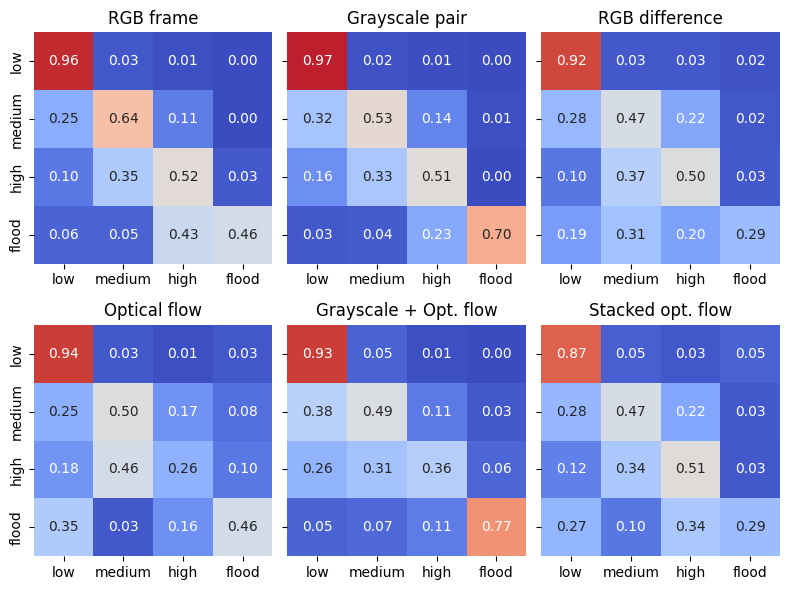

In [14]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + Opt. flow', 'Stacked opt. flow']
lbl_names = ['low', 'medium', 'high', 'flood']

fig = provide_all_subplots(base_paths, plot_titles, figsize=(8,6), lbl_names=lbl_names)
plt.show()
fig.savefig(os.path.join('..','results','cf_level.pdf'))

### Relative water level

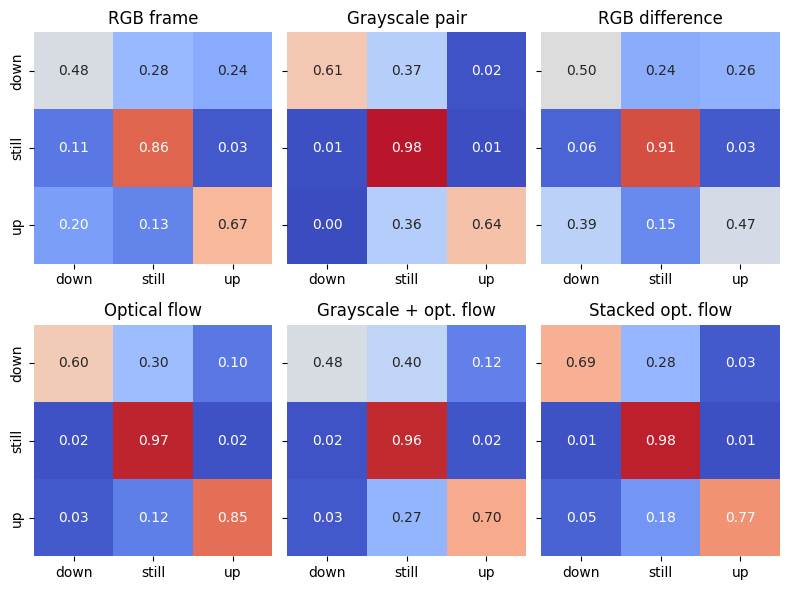

In [15]:
base_paths = list()
base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')


plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + opt. flow', 'Stacked opt. flow']
lbl_names = ['down', 'still', 'up']

fig = provide_all_subplots(base_paths, plot_titles, figsize=(8,6), lbl_names=lbl_names)
plt.show()
fig.savefig(os.path.join('..','results','cf_diffs.pdf'))

# Confidence scores

In [16]:
sns.set(style='darkgrid')

def get_conf(base_path):
    dfs = list()
    for i in range(4):
        path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
        df = pd.read_csv(path, index_col=0)
        dfs.append(df)
    df_conf = pd.concat(dfs, ignore_index=True)
    df_conf = df_conf.rename({'y_true':'Ground truth', 'y_conf':'Confidence'}, axis='columns')
    return df_conf

In [17]:
level_paths = list()
level_paths.append('/models/flow_v0')
level_paths.append('/models/single_rgb_v1')
level_paths.append('/models/single_gray_flow_v0')
level_paths.append('/models/stack_flow_v0')

df_conf = get_conf(level_paths[0])
df_conf.head()

,Ground truth,y_pred,Confidence,datetime
0,0,0,0.999995,2018-11-01 00:17:22
1,0,0,0.999999,2018-11-01 00:33:51
2,0,0,0.999888,2018-11-01 00:50:03
3,0,0,0.999977,2018-11-01 01:06:17
4,0,0,0.999997,2018-11-01 01:22:30


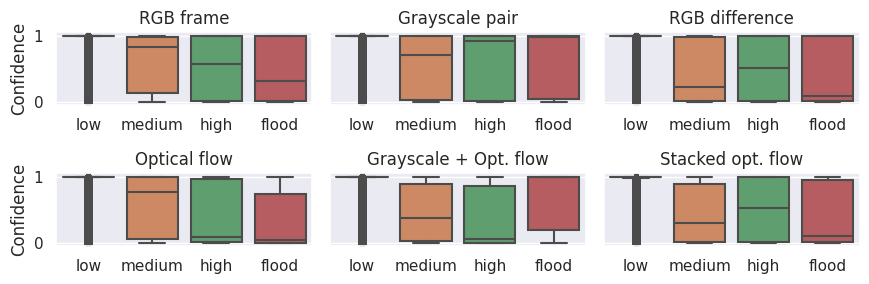

In [19]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + Opt. flow', 'Stacked opt. flow']
lbl_names = ['low', 'medium', 'high', 'flood']

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(9,3))

for i, base_path in enumerate(base_paths):
    df_conf = get_conf(base_paths[i])
    sns.boxplot(ax=axs[i//3,i%3], data=df_conf, x='Ground truth', y='Confidence')
    axs[i//3,i%3].set_title(plot_titles[i])
    axs[i//3,i%3].set_xticklabels(lbl_names)

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')
axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')
axs[1,2].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('')
#axs[1,2].set_visible(False)

fig.tight_layout()

fig.savefig(os.path.join('..','results','confidence_abs.pdf'))
plt.show()

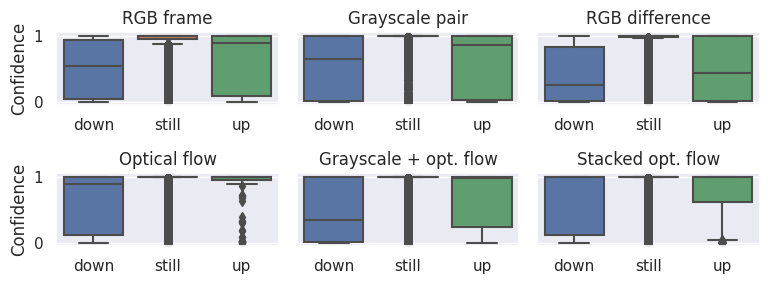

In [21]:
base_paths = list()
base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')

plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + opt. flow', 'Stacked opt. flow']
lbl_names = ['down', 'still', 'up']

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(8,3))

for i, base_path in enumerate(base_paths):
    df_conf = get_conf(base_paths[i])
    sns.boxplot(ax=axs[i//3,i%3], data=df_conf, x='Ground truth', y='Confidence')
    axs[i//3,i%3].set_title(plot_titles[i])
    axs[i//3,i%3].set_xticklabels(lbl_names)

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')
axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')
axs[1,2].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('')
#axs[1,2].set_visible(False)
    
fig.tight_layout()
fig.savefig(os.path.join('..','results','confidence_rel.pdf'))
plt.show()

# Significance test

## Absolute water level - confidence

In [ ]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + Opt. flow', 'Stacked opt. flow']
lbl_names = ['low', 'medium', 'high', 'flood']

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(9,3))

df_conf = get_conf(base_paths[0])
for i, base_path in enumerate(base_paths):
    df_model = get_conf(base_paths[i])
    df_conf = pd.merge(df_conf, df_model, on='datetime')